In [1]:
import numpy as np

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regular as regular

from mlgrad.regr import averaging_function, regression, m_regression_irls, \
                        r_regression_irls, m_regression, \
                        plot_losses_and_errors, plot_yy

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk, mrisk

from pprint import pprint

# from axon import loads, dumps
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
X, Y = load_boston(True, return_X_y=True)
print(X.shape)

# Is = [i for i,y in enumerate(Y) if y != 50]
# X = X[Is]
# Y = Y[Is]

scaler = StandardScaler()
Xt = scaler.fit_transform(X)

(506, 13)


/usr/lib/python3/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass return_X_y=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [3]:
def sigma_neuron_layer2(n_input, n_output):
    outfunc = func.Arctang()
    layer = model.SigmaNeuronModelLayer(outfunc, n_input, n_output)
    return layer

In [4]:
def create_nn(n_input, n_layers):
    body = model.FFNetworkModel()
    n_prev_layer = n_input
    for n_layer in n_layers:
        layer = sigma_neuron_layer2(n_prev_layer, n_layer)
        n_prev_layer = n_layer
        body.add(layer)

    head = model.LinearModel(n_layers[-1])
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
loss_func_sq = loss.RelativeErrorLoss(func.Square())
loss_func_sqrt = loss.RelativeErrorLoss(func.Sqrt(1.0))

In [6]:
n_hidden1 = 13
n_hidden2 = 27
n_hidden3 = 13
n_layers = (n_hidden1, n_hidden2, n_hidden3)
n_input = Xt.shape[1]

In [7]:
ffnn1 = create_nn(n_input, n_layers)
ffnn1.param[:] = np.random.random(size=ffnn1.n_param)
ffnn2 = create_nn(n_input, n_layers)
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)
ffnn3 = create_nn(n_input, n_layers)
ffnn3.param[:] = np.random.random(size=ffnn3.n_param)
# ffnn4 = create_nn(n_input, n_layers)
# ffnn4.param[:] = np.random.random(size=ffnn4.n_param)
ffnn5 = create_nn(n_input, n_layers)
ffnn5.param[:] = np.random.random(size=ffnn5.n_param)

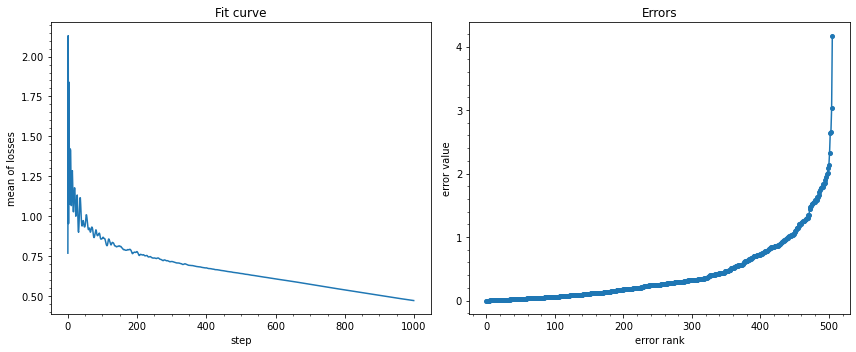

In [8]:
fg_bp = regression(Xt, Y, ffnn1, h=0.01, tol=1.0e-9, n_restart=5)
plot_losses_and_errors(fg_bp, Xt, Y)

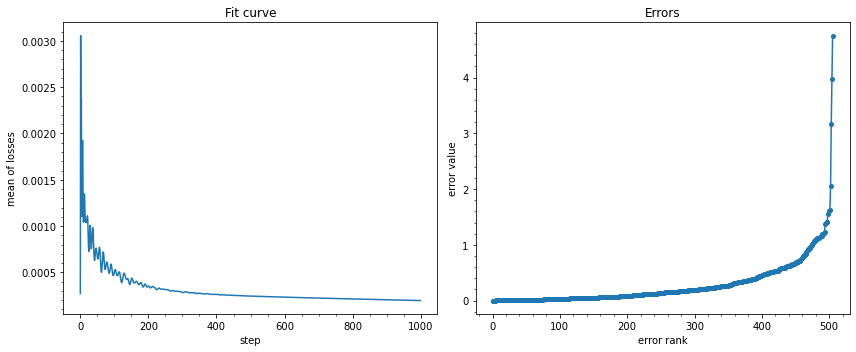

In [9]:
fg_sqrt = regression(Xt, Y, ffnn2, loss_func_sqrt, h=0.01, tol=1.0e-9, n_restart=5)
plot_losses_and_errors(fg_sqrt, Xt, Y)

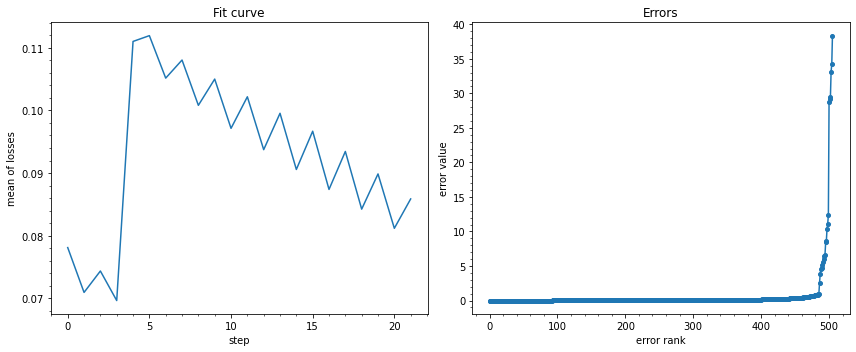

In [21]:
avg_wm = averaging_function("WM", rhofunc=func.Sqrt(0.001), alpha=0.96)
irgd_wm = m_regression_irls(Xt, Y, ffnn3, avrfunc=avg_wm, h=0.001)
plot_losses_and_errors(irgd_wm, Xt, Y)

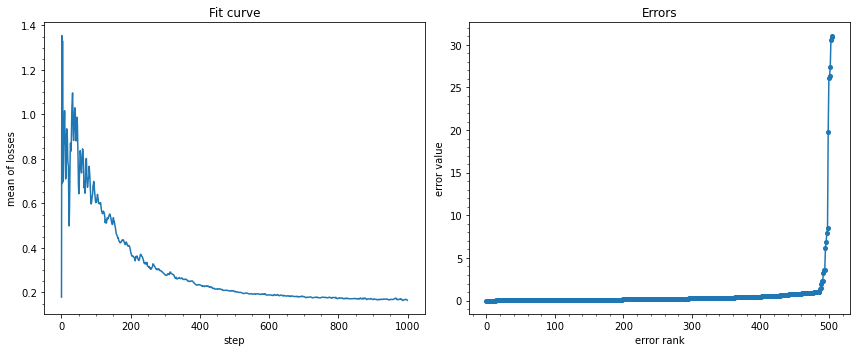

In [22]:
avg_22 = averaging_function("WM", rhofunc=func.Sqrt(0.001), alpha=0.96)
alg_fg2 = m_regression(Xt, Y, ffnn5, avrfunc=avg_22, h=0.01, n_restart=5)
plot_losses_and_errors(alg_fg2, Xt, Y)

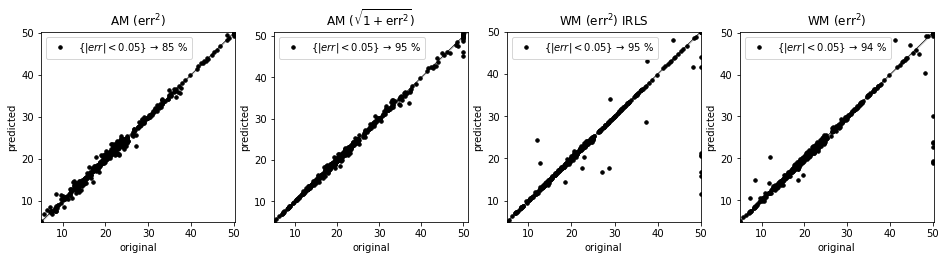

In [23]:
b=0.05
plt.figure(figsize=(4*4.0, 3.5))
plt.subplot(1,4,1)
plot_yy(Xt, Y, ffnn1, r'AM ($\mathrm{err}^2$)', b)
plt.subplot(1,4,2)
plot_yy(Xt, Y, ffnn2, r'AM ($\sqrt{1+\mathrm{err}^2}$)', b)
plt.subplot(1,4,3)
plot_yy(Xt, Y, ffnn3, r'WM ($\mathrm{err}^2$) IRLS', b)
plt.subplot(1,4,4)
plot_yy(Xt, Y, ffnn5, r'WM ($\mathrm{err}^2$)', b)
# plt.tight_layout()
plt.show()

In [24]:
# b = 0.05
# Yp1 = np.array([ffnn1(x) for x in Xt])
# Yp2 = np.array([ffnn2(x) for x in Xt])
# Yp3 = np.array([ffnn3(x) for x in Xt])
# # Yp4 = np.array([ffnn4(x) for x in Xt])
# Yp5 = np.array([ffnn5(x) for x in Xt])
# data = [
#     { 'Y':Yp1, 'title':'AM ($\mathrm{err}^2$)' },
#     { 'Y':Yp2, 'title':'AM ($\sqrt{1+\mathrm{err}^2}$)' },
#     { 'Y':Yp3, 'title':'WM ($\mathrm{err}^2$)'},
# #     { 'Y':Yp4, 'title':'HM ($\mathrm{err}^2$)' },
#     { 'Y':Yp5, 'title':'M ($\mathrm{err}^2$)'},
# ]
# plt.figure(figsize=(len(data)*3.5, 3.5))
# for i, d in enumerate(data):
#     Y1 = d['Y']
#     title = d['title'] 
#     plt.subplot(1, 4, i+1)
#     plt.title(title)
#     V = np.abs((Y-Y1)/Y)
#     I = np.argsort(V)
#     I = I[::-1]
#     plt.scatter(Y[I], Y1[I], c=V[I], s=12, cmap=plt.cm.gray)
#     c = sum(V < b) / len(V) * 100
#     plt.text(0, 49, r'$(|err|<%.2f)\to%s$ %%' % (b, int(c)))
#     plt.plot([0,50],[0,50], c='k')
#     if i == 1:
#         plt.xlabel("original target")
#     if i == 0:
#         plt.ylabel("predicted target")
#     plt.ylim(0, 52)
#     plt.minorticks_on()
# plt.savefig(r"fig/isnn2019_boston_%s.eps" % str(n_layers))
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(len(data)*3.5, 3.5))
for i, d in enumerate(data):
    Y1 = d['Y']
    title = d['title'] 
    plt.subplot(1, 4, i+1)
    plt.title(title)
    V = np.abs((Y-Y1)/Y)
    Vs = np.sort(V)
    plt.plot(Vs, c='k', ms=4, marker='o')
    plt.ylim(0,0.1)
    plt.minorticks_on()
plt.savefig(r"fig/nn_boston_%s.pdf" % str(n_layers))
plt.tight_layout()
plt.show()

NameError: name 'data' is not defined

In [ ]:
plt.figure(figsize=(6,4.5))
plt.title('NN %s' % str(n_layers))
Z = np.abs((Yp1-Y)/Y)
Z2 = np.abs((Yp2-Y)/Y)
Z3 = np.abs((Yp3-Y)/Y)
# Z4 = np.abs((Yp4-Y)/Y)
Z5 = np.abs((Yp5-Y)/Y)
plt.plot(sorted(Z), label='ER', color='k', linestyle='-.', linewidth=2.0)
plt.plot(sorted(Z2), label='R', color='k', linestyle=':', linewidth=2.0)
plt.plot(sorted(Z3), label='WM', color='k', linestyle='--', linewidth=2.0)
# plt.plot(sorted(Z4), label='HM', color='k', linestyle='-', linewidth=2.0)
plt.plot(sorted(Z5), label='M', color='k', linestyle='-', linewidth=2.0)
plt.hlines(b, 0, 500)
plt.legend()
plt.ylim(-0.1, 0.2)
plt.savefig(r"fig/nn_boston_1_%s_%s_%s.pdf" % (n_hidden1, n_hidden2, n_hidden3))
plt.minorticks_on()
plt.xlabel("Error's rank")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.show()